In [125]:
TRAIN = 1
REBUILD_DATA = 1
REDEFINE_MODEL = 1

# We will process maxToAdd frames each video to recognize facial expression
maxToAdd = 24
size = 48
# size = 224

# n_classes = 2
n_classes = 7

batch_size = 197
# batch_size = 32
n_epochs = 200

learning_rate = 0.0001
early_stop_after = 20

# SUFFIX = 'cluster'
SUFFIX = 'original'

PATH_TRAIN = 'E:/EmotiW2017/lstm/original/Train_AFEW_' + SUFFIX
# PATH_TRAIN = 'E:/EmotiW2017/lstm/aligned_original/Train_AFEW'
# PATH_VAL = 'E:/EmotiW2017/lstm/original/Val_AFEW'
PATH_VAL = 'E:/EmotiW2017/lstm/original/Val_AFEW_' + SUFFIX
# PATH_VAL = 'E:/EmotiW2017/lstm/aligned/Val_AFEW'

NPY_X_TRAIN_DATA = 'training_data_x_' + SUFFIX + '_' + str(size) + '_' + str(maxToAdd) + '_' + str(n_classes) + '.npy'
NPY_Y_TRAIN_DATA = 'training_data_y_' + SUFFIX + '_' + str(size) + '_' + str(maxToAdd) + '_' + str(n_classes) + '.npy'

NPY_X_TEST_DATA = 'testing_data_x_' + SUFFIX + '_' + str(size) + '_' + str(maxToAdd) + '_' + str(n_classes) + '.npy'
NPY_Y_TEST_DATA = 'testing_data_y_' + SUFFIX + '_' + str(size) + '_' + str(maxToAdd) + '_' + str(n_classes) + '.npy'

# NPY_X_TEST_DATA = 'testing_data_x_a.npy'
# NPY_Y_TEST_DATA = 'testing_data_y_a.npy'

MODEL_ARCH_FILE = 'cnn_lstm_afew2017_' + SUFFIX + '_' + str(size) + '_' + str(maxToAdd) + '_' + str(n_classes) + '_.json'
WEIGHT_FILE = 'cnn_lstm_afew2017_' + SUFFIX + '_' + str(size) + '_' + str(maxToAdd) + '_' + str(n_classes) + '_.hdf5'
TRAINING_HIST = 'cnn_lstm_afew2017_' + SUFFIX + '_' + str(size) + '_' + str(maxToAdd) + '_' + str(n_classes) + '_.pickle'

In [126]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import cv2
import time
import json
import pickle

from tensorflow.contrib.keras.python.keras.datasets import mnist
from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers.recurrent import SimpleRNN, LSTM, GRU
from tensorflow.contrib.keras.python.keras.optimizers import RMSprop, Adadelta, Adam
from tensorflow.contrib.keras.python.keras.layers import Convolution2D, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.contrib.keras.python.keras.layers.core import Dense, Activation, Dropout, Reshape, Flatten
from tensorflow.contrib.keras.python.keras.layers.wrappers import TimeDistributed
from tensorflow.contrib.keras.python.keras.callbacks import EarlyStopping
from tensorflow.contrib.keras.python.keras.regularizers import l1, l2
from tensorflow.contrib.keras.python.keras.utils.vis_utils import plot_model
from tensorflow.contrib.keras.python.keras.layers.normalization import BatchNormalization
from tensorflow.contrib.keras.python.keras import models

from tensorflow.contrib.keras.python.keras.models import model_from_json

from tensorflow.contrib.keras.python.keras import backend as K

from natsort import natsorted
from IPython.display import clear_output

# VGG-FACE
from tensorflow.contrib.keras.python.keras.preprocessing import image
from tensorflow.contrib.keras.python.keras.engine import Model
# from keras_vggface.vggface import VGGFace

# Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

K.set_learning_phase(1)

In [127]:
def emo2int(emo):
    if n_classes == 7:
        if emo == 'Angry':
            return 0
        elif emo == 'Disgust':
            return 1
        elif emo == 'Fear':
            return 2
        elif emo == 'Happy':
            return 3
        elif emo == 'Neutral':
            return 4
        elif emo == 'Sad':
            return 5
        else:
            return 6
    else:
        if emo == 'angry_happy_neutral':
            return 0
        else:
            return 1

In [128]:
# def emo2int(emo):
#     if emo == 'angry_happy_neutral':
#         return 0
#     else:
#         return 1

In [129]:
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Training data

#### Count # of video in training data

In [130]:
if REBUILD_DATA == 1:
    n_vids_train = 0

    for emo in os.listdir(PATH_TRAIN):
        full_emo = PATH_TRAIN + '/' + emo
        if os.path.isdir(full_emo):
            for vid in os.listdir(full_emo):
                full_vid = full_emo + '/' + vid

                n_vids_train += 1

    print(' > %d videos found' % (n_vids_train))

 > 726 videos found


#### Count # of frames in each video in training data

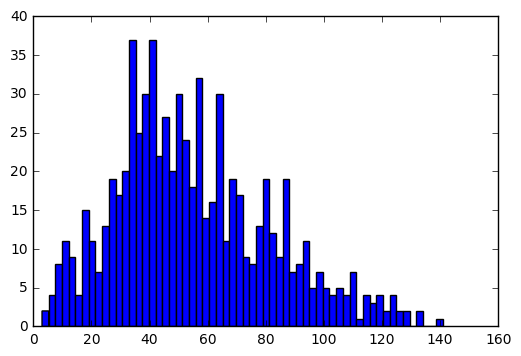

In [131]:
if REBUILD_DATA == 1:
    n_fra_stat_train = np.zeros((n_vids_train, 1))

    vid_indx = 0

    for emo in os.listdir(PATH_TRAIN):
        full_emo = PATH_TRAIN + '/' + emo
        if os.path.isdir(full_emo):
            for vid in os.listdir(full_emo):
                full_vid = full_emo + '/' + vid
                for fra in os.listdir(full_vid):
                    full_fra = full_vid + '/' + fra
                    if os.path.isfile(full_fra):
                        n_fra_stat_train[vid_indx, 0] += 1

                vid_indx += 1

    plt.hist(n_fra_stat_train, bins=60)
    plt.show()

In [132]:
if REBUILD_DATA == 1:
    print(np.average(n_fra_stat_train))
    print(stats.mode(n_fra_stat_train))

55.0716253444
ModeResult(mode=array([[ 39.]]), count=array([[18]]))


> generating training data...done.
X_train shape:  (726, 24, 48, 48, 1)
y_train shape:  (726,)
7 emotions found


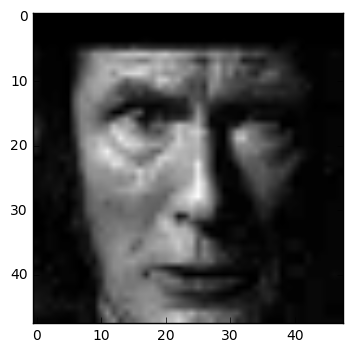

In [133]:
n_emos = 0
for emo in os.listdir(PATH_TRAIN):
    n_emos += 1

if REBUILD_DATA == 0 and os.path.isfile(NPY_X_TRAIN_DATA) and os.path.isfile(NPY_Y_TRAIN_DATA):
    print('> loading training data...', end='')
    X_train = np.load(NPY_X_TRAIN_DATA)
    y_train = np.load(NPY_Y_TRAIN_DATA)
    print('done.')
else:
    print('> generating training data...', end='')
    X_train = []
    y_train = []

    X_train = np.zeros((n_vids_train, maxToAdd, size, size, 1))

    vid_indx = 0
    
    n_emos = 0

    for emo in os.listdir(PATH_TRAIN):
        full_emo = PATH_TRAIN + '/' + emo
        n_emos += 1
        if os.path.isdir(full_emo):
            for vid in os.listdir(full_emo):
                full_vid = full_emo + '/' + vid

                # Initialize a training example of max_num_time_steps, im_size, im_size
                output = np.zeros((maxToAdd, size, size, 1))

                # Decide how many images to put in that tensor
                numToAdd = int(np.min((maxToAdd, n_fra_stat_train[vid_indx, 0])))

                # Sample that images
                fra_indx = 0
                example = np.zeros((numToAdd, size, size))
                for fra in os.listdir(full_vid):
                    if fra_indx < numToAdd:
                        full_fra = full_vid + '/' + fra
                        if os.path.isfile(full_fra):
                            img = cv2.imread(full_fra)
                            img = cv2.resize(img, (size, size))
                            img = img[:, :, 0]
                            example[fra_indx] = img

                            fra_indx += 1
                    else:
                        break

                output[0:numToAdd, :, :, 0] = example
                X_train[vid_indx, :, :, :, :] = output

                # Get the label for current video
                y_train.append(emo2int(emo))

                vid_indx += 1

    y_train = np.array(y_train)
    print('done.')
    
    np.save(NPY_X_TRAIN_DATA, X_train)
    np.save(NPY_Y_TRAIN_DATA, y_train)
    
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print('%d emotions found' % (n_emos))

plt.imshow(X_train[0, 0, :, :, 0], cmap='gray')
plt.show()

# Validation data

In [134]:
n_vids_test = 0

for emo in os.listdir(PATH_VAL):
    full_emo = PATH_VAL + '/' + emo
    if os.path.isdir(full_emo):
        for vid in os.listdir(full_emo):
            full_vid = full_emo + '/' + vid
            
            n_vids_test += 1

print(' > %d videos found' % (n_vids_test))

 > 383 videos found


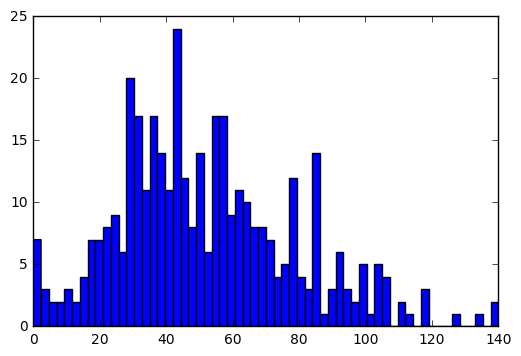

In [135]:
n_fra_stat_test = np.zeros((n_vids_test, 1))

vid_indx = 0

for emo in os.listdir(PATH_VAL):
    full_emo = PATH_VAL + '/' + emo
    if os.path.isdir(full_emo):
        for vid in os.listdir(full_emo):
            full_vid = full_emo + '/' + vid
            for fra in os.listdir(full_vid):
                full_fra = full_vid + '/' + fra
                if os.path.isfile(full_fra):
                    n_fra_stat_test[vid_indx, 0] += 1
                    
            vid_indx += 1

plt.hist(n_fra_stat_test, bins=60)
plt.show()

In [136]:
print(np.average(n_fra_stat_test))
print(stats.mode(n_fra_stat_test))

51.8825065274
ModeResult(mode=array([[ 54.]]), count=array([[11]]))


> generating validation data...done.
X_test shape:  (383, 24, 48, 48, 1)
y_test shape:  (383,)
7 emotions found


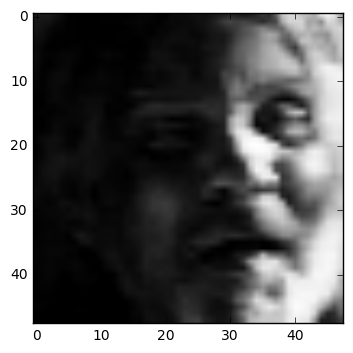

In [137]:
n_emos = 0
for emo in natsorted(os.listdir(PATH_VAL)):
    n_emos += 1

if REBUILD_DATA == 0 and os.path.isfile(NPY_X_TEST_DATA) and os.path.isfile(NPY_Y_TEST_DATA):
    print('> loading validation data...', end='')
    X_test = np.load(NPY_X_TEST_DATA)
    y_test = np.load(NPY_Y_TEST_DATA)
    print('done.')
else:
    print('> generating validation data...', end='')
    X_test = []
    y_test = []

    X_test = np.zeros((n_vids_test, maxToAdd, size, size, 1))

    vid_indx = 0
    
    n_emos = 0

    for emo in natsorted(os.listdir(PATH_VAL)):
        full_emo = PATH_VAL + '/' + emo
        n_emos += 1
        if os.path.isdir(full_emo):
            for vid in natsorted(os.listdir(full_emo)):
                full_vid = full_emo + '/' + vid

                # Initialize a testing example of max_num_time_steps, im_size, im_size
                output = np.zeros((maxToAdd, size, size, 1))

                # Decide how many images to put in that tensor
                numToAdd = int(np.min((maxToAdd, n_fra_stat_test[vid_indx, 0])))

                # Sample that images
                fra_indx = 0
                example = np.zeros((numToAdd, size, size))
                for fra in natsorted(os.listdir(full_vid)):
                    if fra_indx < numToAdd:
                        full_fra = full_vid + '/' + fra
                        if os.path.isfile(full_fra):
                            img = cv2.imread(full_fra)
                            img = cv2.resize(img, (size, size))
                            img = img[:, :, 0]
                            example[fra_indx] = img

                            fra_indx += 1
                    else:
                        break

                output[0:numToAdd, :, :, 0] = example
                X_test[vid_indx, :, :, :, :] = output

                # Get the label for current video
                y_test.append(emo2int(emo))

                vid_indx += 1

    y_test = np.array(y_test)
    print('done.')
    
    np.save(NPY_X_TEST_DATA, X_test)
    np.save(NPY_Y_TEST_DATA, y_test)
    
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
print('%d emotions found' % (n_emos))

plt.imshow(X_test[0, 0, :, :, 0], cmap='gray')
plt.show()

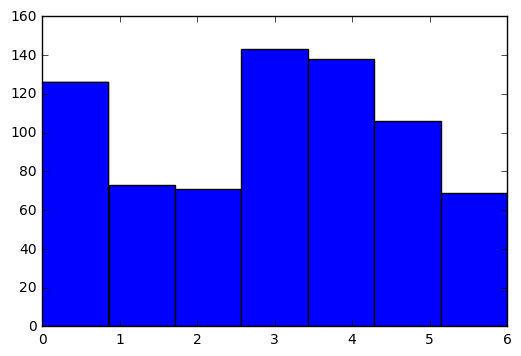

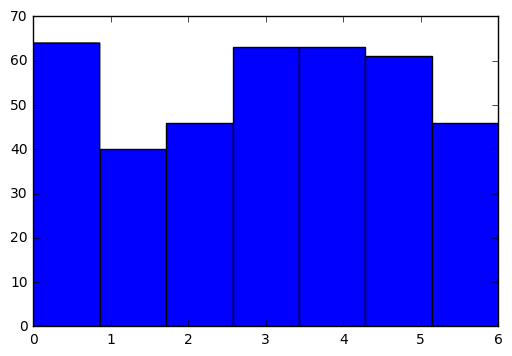

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5,

In [138]:
plt.hist(y_train, bins=n_classes)
plt.show()

plt.hist(y_test, bins=n_classes)
plt.show()

y_test

# CNN-LSTM

In [139]:
if os.path.isfile(MODEL_ARCH_FILE) and REDEFINE_MODEL == 0:
    print('Loading model...', end='')
    with open(MODEL_ARCH_FILE, 'r') as f:
        json_string = f.read()
    model = model_from_json(json_string)
    print('done.')
else:
    print('Defining model...', end='')

# 1111111111111111
    # Define CNN-LSTM
    model = Sequential()

    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='valid'), input_shape=(maxToAdd, size, size, 1)))

    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (1, 1), activation='relu', padding='same')))

    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))

    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(128, (1, 1), activation='relu', padding='same')))
    
    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')))

    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')))

    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(256, (1, 1), activation='relu', padding='same')))

    model.add(TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same')))
    
    model.add(TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same')))
    
    model.add(TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same')))

    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(Activation('relu'))

#     model.add(LSTM(units=1024, return_sequences=True))
    model.add(LSTM(units=1024, return_sequences=False))
    # model.add(LSTM(units=512, return_sequences=True))
    # model.add(LSTM(units=512, return_sequences=False))

    # model.add(Dense(n_classes, activation='softmax', kernel_regularizer=l2(0.001)))
    model.add(Dense(n_classes, activation='softmax'))

# # 22222222222222
#     model = Sequential()
#     model.add(TimeDistributed(Conv2D(8, (4, 4), padding='valid'), input_shape=(maxToAdd, size, size, 1)))
#     model.add(Activation('relu'))

#     model.add(TimeDistributed(Conv2D(16, (3, 3), padding='valid')))
#     model.add(Activation('relu'))
    
#     model.add(TimeDistributed(Flatten()))
#     model.add(Activation('relu'))
    
#     model.add(GRU(units=100, return_sequences=True))
#     model.add(Dropout(0.2))
#     model.add(GRU(units=50, return_sequences=False))
#     model.add(Dropout(0.2))
#     model.add(Dense(n_classes, activation='softmax'))
    
#     # VGG-FACE
#     input_shape = (maxToAdd, 224, 224, 1)
    
#     vgg_face = Sequential()

#     # Block 1
#     vgg_face.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu', padding='same', name='conv1_1', trainable=False), input_shape=input_shape))
#     vgg_face.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu', padding='same', name='conv1_2', trainable=False)))
#     vgg_face.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2), name='pool1', trainable=False)))

#     # Block 2
#     vgg_face.add(TimeDistributed(Convolution2D(128, (3, 3), activation='relu', padding='same', name='conv2_1', trainable=False)))
#     vgg_face.add(TimeDistributed(Convolution2D(128, (3, 3), activation='relu', padding='same', name='conv2_2', trainable=False)))
#     vgg_face.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2), name='pool2', trainable=False)))

#     # Block 3
#     vgg_face.add(TimeDistributed(Convolution2D(256, (3, 3), activation='relu', padding='same', name='conv3_1', trainable=False)))
#     vgg_face.add(TimeDistributed(Convolution2D(256, (3, 3), activation='relu', padding='same', name='conv3_2', trainable=False)))
#     vgg_face.add(TimeDistributed(Convolution2D(256, (3, 3), activation='relu', padding='same', name='conv3_3', trainable=False)))
#     vgg_face.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2), name='pool3', trainable=False)))

#     # Block 4
#     vgg_face.add(TimeDistributed(Convolution2D(512, (3, 3), activation='relu', padding='same', name='conv4_1', trainable=False)))
#     vgg_face.add(TimeDistributed(Convolution2D(512, (3, 3), activation='relu', padding='same', name='conv4_2', trainable=False)))
#     vgg_face.add(TimeDistributed(Convolution2D(512, (3, 3), activation='relu', padding='same', name='conv4_3', trainable=False)))
#     vgg_face.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2), name='pool4', trainable=False)))

#     # Block 5
#     vgg_face.add(TimeDistributed(Convolution2D(512, (3, 3), activation='relu', padding='same', name='conv5_1', trainable=False)))
#     vgg_face.add(TimeDistributed(Convolution2D(512, (3, 3), activation='relu', padding='same', name='conv5_2', trainable=False)))
#     vgg_face.add(TimeDistributed(Convolution2D(512, (3, 3), activation='relu', padding='same', name='conv5_3', trainable=False)))
#     vgg_face.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2), name='pool5', trainable=False)))
#     vgg_face.add(TimeDistributed(Flatten(name='output', trainable=False)))

#     weights_path = 'rcmalli_vggface_tf_notop_v2.h5'
#     vgg_face.load_weights(weights_path, by_name=True)
    
#     x = vgg_face.output
#     x = GRU(units=100, return_sequences=True, name='GRU_1')(x)
#     x = GRU(units=50, return_sequences=False, name='GRU_2')(x)
#     x = Dropout(0.2, name='dropout')(x)
#     predictions = Dense(n_classes, activation='softmax', name='softmax')(x)
    
#     model = Model(inputs=vgg_face.input, outputs=predictions)
    
# # 3333333333333333
#     model = Sequential()
#     model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='valid'), input_shape=(maxToAdd, size, size, 1)))
#     model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))
#     model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
#     model.add(TimeDistributed(Dropout(0.25)))

#     model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
#     model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
#     model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
#     model.add(TimeDistributed(Dropout(0.25)))

#     model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')))
#     model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
#     model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
#     model.add(TimeDistributed(Dropout(0.25)))

#     model.add(TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same')))
#     model.add(TimeDistributed(Conv2D(256, (3, 3), activation='relu')))
#     model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
#     model.add(TimeDistributed(Dropout(0.25)))

#     model.add(TimeDistributed(Flatten()))
#     model.add(Activation('relu'))
    
#     model.add(LSTM(units=1024, return_sequences=True, recurrent_dropout=0.2, kernel_regularizer=l2(0.001)))
#     model.add(Dropout(0.25))
#     model.add(LSTM(units=512, return_sequences=False))
#     model.add(Dense(n_classes, activation='softmax'))
    
    with open(MODEL_ARCH_FILE, 'w') as outfile:
        outfile.write(json.dumps(json.loads(model.to_json()), indent=2))
    
#     opt = Adam(lr=learning_rate)
    opt = RMSprop(lr=learning_rate)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    print(model.summary())
    
    print('done.')

Defining model..._________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_126 (TimeDi (None, 24, 46, 46, 64)    640       
_________________________________________________________________
time_distributed_127 (TimeDi (None, 24, 23, 23, 64)    0         
_________________________________________________________________
time_distributed_128 (TimeDi (None, 24, 23, 23, 64)    0         
_________________________________________________________________
time_distributed_129 (TimeDi (None, 24, 23, 23, 64)    4160      
_________________________________________________________________
time_distributed_130 (TimeDi (None, 24, 23, 23, 64)    36928     
_________________________________________________________________
time_distributed_131 (TimeDi (None, 24, 11, 11, 64)    0         
_________________________________________________________________
time_distributed_132 (TimeDi (None, 24, 11, 11, 64)    0   

In [140]:
if TRAIN == 1:
#     batch_size = 197
    batch_size = 64
    n_epochs = 500

    learning_rate = 0.0001
    early_stop_after = 50
    
    start_time = time.time()

    early_stopping = EarlyStopping(monitor='val_loss', patience=early_stop_after, verbose=1)

    train_history = model.fit(X_train, y_train,
              validation_data=(X_test, y_test),
              shuffle=True, batch_size=batch_size, epochs=n_epochs, verbose=1,
              callbacks=[early_stopping])
    
    training_time = time.time() - start_time
    print('> Training time on GTX1080: ' + str(training_time) + ' sec')

Train on 726 samples, validate on 383 samples
Epoch 1/500
726/726 [==============================] - 8s - loss: 2.0723 - acc: 0.1736 - val_loss: 1.9440 - val_acc: 0.1906
Epoch 2/500
726/726 [==============================] - 6s - loss: 1.9030 - acc: 0.1915 - val_loss: 1.9412 - val_acc: 0.2063
Epoch 3/500
726/726 [==============================] - 6s - loss: 1.8913 - acc: 0.2025 - val_loss: 1.9787 - val_acc: 0.1697
Epoch 4/500
726/726 [==============================] - 6s - loss: 1.8943 - acc: 0.2094 - val_loss: 1.9766 - val_acc: 0.2063
Epoch 5/500
726/726 [==============================] - 6s - loss: 1.8929 - acc: 0.2231 - val_loss: 1.9570 - val_acc: 0.1619
Epoch 6/500
726/726 [==============================] - 6s - loss: 1.8838 - acc: 0.2328 - val_loss: 1.9879 - val_acc: 0.1880
Epoch 7/500
726/726 [==============================] - 6s - loss: 1.8805 - acc: 0.2383 - val_loss: 1.9564 - val_acc: 0.1828
Epoch 8/500
726/726 [==============================] - 6s - loss: 1.8770 - acc: 0.2369

726/726 [==============================] - 6s - loss: 0.0096 - acc: 1.0000 - val_loss: 4.5529 - val_acc: 0.2402
Epoch 67/500
726/726 [==============================] - 6s - loss: 0.0055 - acc: 1.0000 - val_loss: 4.7871 - val_acc: 0.2272
Epoch 00066: early stopping
> Training time on GTX1080: 447.2485454082489 sec


In [141]:
if TRAIN == 1:
    # Save trained model
    model.save_weights(WEIGHT_FILE)    
    # Save training history
    with open(TRAINING_HIST, 'wb') as f:
        pickle.dump(train_history.history, f)
        
    history_ = train_history.history
else:
    # Load trained model
    model.load_weights(WEIGHT_FILE)
    
    # Load training history
    file = open(TRAINING_HIST, 'rb')
    history_ = pickle.load(file)

In [142]:
# plot_model(model, to_file='model.png', show_shapes=True)

In [143]:
score = model.evaluate(X_train, y_train)
print('Train score:', score[0])
print('Train accuracy:', score[1])

score = model.evaluate(X_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

726/726 [==============================] - 2s     
Train score: 0.00327537632124
Train accuracy: 1.0
383/383 [==============================] - 1s     
Test score: 4.71165066662
Test accuracy: 0.234986944781


In [144]:
# y_test
y_pred_training_ = model.predict(x=X_train, batch_size=batch_size, verbose=1)
y_pred_ = model.predict(x=X_test, batch_size=batch_size, verbose=1)

383/383 [==============================] - 0s     


In [145]:
# cm = confusion_matrix(y_test, y_pred)
# cm = [cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]]
# cm

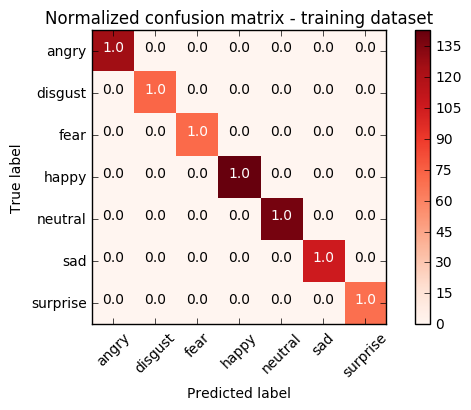

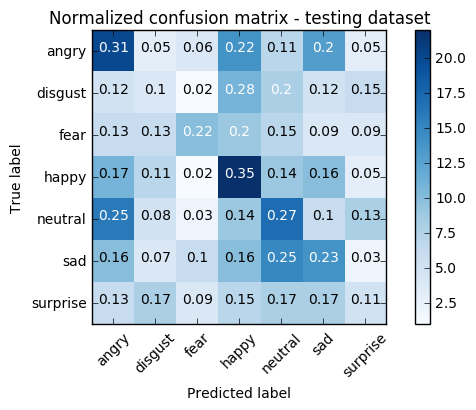

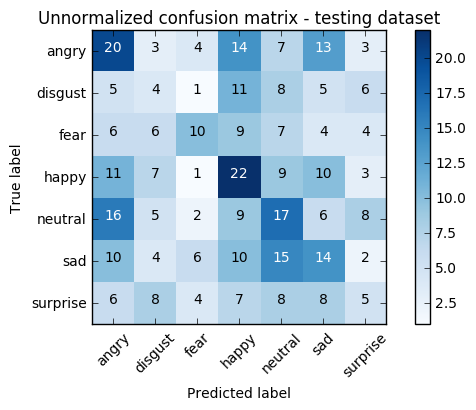

In [146]:
y_pred_training = np.argmax(y_pred_training_, axis=1)
y_pred = np.argmax(y_pred_, axis=1)
# np.sum(y_pred == y_test)/y_test.shape[0]

classes=np.array(('angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'))
# classes=np.array(('angry_happy_neutral', 'disgust_fear_sad_surprise'))

plot_confusion_matrix(y_test=y_train, y_pred=y_pred_training,
                      classes=classes,
                      normalize=True,
                      title='Normalized confusion matrix - training dataset',
                      cmap=plt.cm.Reds)

# plot_confusion_matrix(y_test=y_train, y_pred=y_pred_training,
#                       classes=classes,
#                       normalize=False,
#                       title='Unnormalized confusion matrix - training dataset',
#                       cmap=plt.cm.Reds)

plot_confusion_matrix(y_test=y_test, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      title='Normalized confusion matrix - testing dataset')

plot_confusion_matrix(y_test=y_test, y_pred=y_pred,
                      classes=classes,
                      normalize=False,
                      title='Unnormalized confusion matrix - testing dataset')

dict_keys(['val_acc', 'acc', 'loss', 'val_loss'])


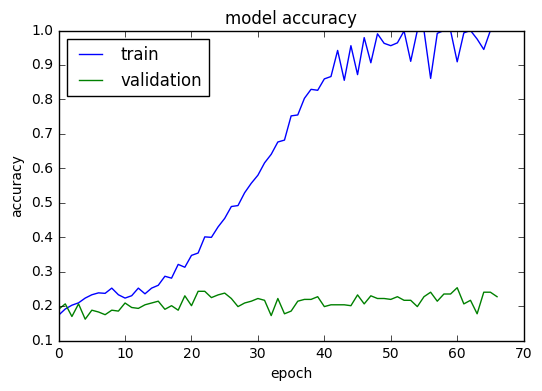

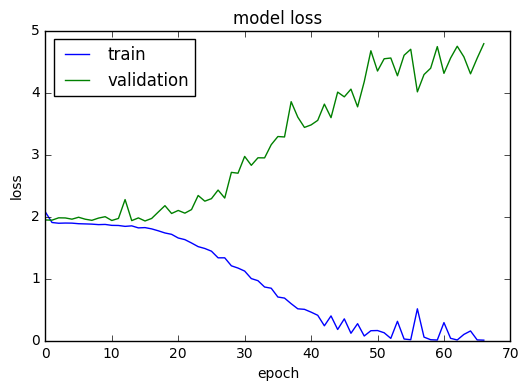

In [147]:
# list all data in history
print(history_.keys())
# summarize history for accuracy
plt.plot(history_['acc'])
plt.plot(history_['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_['loss'])
plt.plot(history_['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()